[//]: # "Para temas claros usar logo_utn.svg"
<img src="./logo_utn_dark.png" align="right" width="250" /> 

# Análisis de la sensibilidad en la topología Sallen-Key

#### Por Mariano Llamedo Soria

### Introducción


En el siguiente documento se analizará la dispersión de parámetros:

 * Factor de selectividad ($Q$)
 * Frecuencia de corte o resonancia ($\omega_0$)
 * y la ganancia ($K$)

correspondiente a una topología Sallen-Key en su configuración pasabajo, mediante la siguiente red:


<img src="./sallenkey.png" align="center" width="700" style="border:10px solid white" /> 

Este circuito implementa la siguiente transferencia de tensión:

$$ T(s) =\frac{V_o}{V_i} = \frac{ K·\omega_0^2}{s^2 + s · \omega_0/Q + \omega_0^2} $$

En las siguientes secciones se describirá la relación entre los parámetros y los elementos circuitales.

Esta topología fue propuesta originalmente en 1955 por R. P. Sallen and E. L. Key del [laboratorio Lincoln](https://en.wikipedia.org/wiki/MIT_Lincoln_Laboratory), en el MIT [[wiki]](https://en.wikipedia.org/wiki/Sallen%E2%80%93Key_topology). Es uno de los primeros filtros activos publicados, y posiblemente uno de los más populares. Una de sus principales ventajas al momento de su publicación fue la posibilidad de diseñar filtros de orden superior de forma modular. Es decir que cada etapa podía diseñarse por separado debido al uso de seguidores de tensión, o lo que se consideró años después, la topología de filtos *fuente de tensión controlada por tensión* (VCVS por sus siglas en inglés). Otra ventaja importante es que necesita un solo dispositivo activo, en nuestro caso un *opamp*, aunque la publicación original se propuso un amplificador valvular en configuración de cátodo común. La idea original fue que el dispositivo activo funcione aproximadamente como un *buffer*, proveyendo separación de las secciones adyacentes (casi) sin atenuación de la señal. En el caso de la configuración actual, el *opamp* también permite obtener ganancia, como veremos más adelante. Ciertamente esta topología tiene varias desventajas, posiblemente la más notoria es su dificultad de implementar factores de selectividad (Q) elevados, como se analizará en este documento.

<a id='indice'></a>

Se seguirá el siguiente orden a lo largo del documento:

1. Simulación simbólica:

    a. [Análisis teórico de la función transferencia](#1.a).

    b. [Asumiendo realimentación negativa (RN) con opamp ideal](#1.b).
    
    c. [Sin asumir RN con opamp ideal](#1.c).
    
    d. [Sin asumir RN y con opamp NO ideal](#1.d).
    
    e. [Análisis de sensibilidad](#1.e).
    
2. Simulación numérica.
    
    a. [Simulación numérica: Análisis Montecarlo](#2.a).
    
    b. [Resultados cualitativos (gráficas)](#2.b).

    c. [Resultados cuantitativos (tablas)](#2.c).

    d. [Conclusiones](#2.d).

3. Simulación circuital.

    a. [Circuito analizado](#3.a).

    b. [Resultados cualitativos (gráficas)](#3.b).

    c. [Análisis de las mediciones automáticas](#3.c).

    d. [Resultados cuantitativos](#3.d).

    e. [Conclusiones](#3.e).



<a id='1.a'></a>

### 1.a) Análisis teórico de la función transferencia


Se comienza analizando las ecuaciones que gobiernan el comportamiento de la red propuesta:


 1. Nodo $V_b$
 
  $ V_b . (G_1 + G_2 + s.C) - V_i . G_1 - V_a . G_2  - V_o . s.C = 0$


 2. Nodo $V_a$ ó $V_+$
 
  $ -V_b . G_2 + V_a . (G_2 + s.C) = 0$


 3. Nodo $V_-$
 
  $ V_- . (G_a + G_b) - V_o . G_b = 0$


Si consideramos que la red está **realimentada negativamente**, podemos agregar la siguiente ecuación:


 4. $V_- = V_+ = V_a$
 
  
y proceder a resolver el sistema de ecuaciones para $\frac{V_o}{V_i}$, lo cual concluiría el análisis de la transferencia del filtro. 

Sin embargo, a modo de ejemplo, demostraremos las posibilidades de sympy para el manejo de expresiones algebraicas analizando la red como si no supiéramos de qué clase de realimentación se trata. Para tal fin debemos contemplar la siguiente ecuación que describe el funcionamiento del *opamp*.


 4. (bis) $ (V_+ - V_-). A(s) = (V_a - V_-). A(s) = V_o$
 
Luego si asumimos $A(s) \to \infty$ para una salida $V_o$ finita, entonces 4 (bis) se convierte en la ecuación 4. Finalmente, el comportamiento del *opamp* también puede hacerse tan complejo como se desee, por caso usando el modelo de integrador


 5. $ A(s) = \frac{\omega_t}{s}$


Dependiendo la complejidad del análisis podemos optar por cualquiera de los tres caminos sugeridos más arriba. A modo de ejemplo, resolveremos los tres para presentar las posibilidades de sympy.

[Volver al índice](#indice)

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos externos
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import TransferFunction

fig_sz_x = 8
fig_sz_y = 6
fig_dpi = 150 # dpi

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi

plt.figure(1)
plt.plot(np.random.rand(10))
plt.close(1)

# módulo de análisis simbólico
import sympy as sp
# variable de Laplace
from sympy.abc import s
from IPython.display import display, Math, Markdown

# Ahora importamos las funciones de PyTC2
from pytc2.sistemas_lineales import simplify_n_monic, parametrize_sos
from pytc2.general import print_subtitle


<a id='1.b'></a>

### 1.b) Alternativa 1: Red negativamente realimentada 

Procedemos a ingresar las ecuaciones 1-4.

[Volver al índice](#indice)

In [2]:

# variables simbólicas
s = sp.symbols('s', complex=True)
Va, Vb, Vi, Vo = sp.symbols("Va, Vb, Vi, Vo")
G1, G2, Ga, Gb, C, As, wt = sp.symbols("G1, G2, Ga, Gb, C, As, wt")

# Sistemas de ecuaciones del modelo ideal, negativamente realimentado
aa = sp.solve([ 
                Vb*(G1 + G2 + s*C) - Vi * G1 - Va * G2 - Vo * s*C, 
                -Vb*G2 + Va * (G2 + s*C),
                -Vo*Gb + Va * (Ga + Gb)
                ], 
                [Vo, Vi, Va, Vb])
T1 = aa[Vo]/aa[Vi]

num, den = sp.fraction(sp.simplify(sp.expand(T1)))
num = sp.Poly(num,s)
den = sp.Poly(den,s)
num1, den1, w_on, Q_n, w_od, Q_d, k1 = parametrize_sos(num, den)

print_subtitle('Transferencia obtenida')

display(Math( r' \frac{V_o}{V_i} = ' + sp.latex(sp.Mul(k1,num1/den1, evaluate=False)) ))

print_subtitle('Parámetros')

display(Math( r' k = ' + sp.latex(k1) ))

display(Math( r' \omega_0 = ' + sp.latex(w_od) ))

display(Math( r' Q = ' + sp.latex(Q_d) ))


#### Transferencia obtenida

<IPython.core.display.Math object>

#### Parámetros

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<a id='1.c'></a>

### 1.c) Alternativa 2: Sin asumir realimentación negativa (RN) 

Procedemos a ingresar las ecuaciones 1-3 y 4bis.

[Volver al índice](#indice)

In [3]:

# pata inversora del opamp
Vinv  = sp.symbols("Vinv")

# Sistemas de ecuaciones del modelo ideal, negativamente realimentado
aa = sp.solve([ 
                Vb*(G1 + G2 + s*C) - Vi * G1 - Va * G2 - Vo * s*C, 
                -Vb*G2 + Va * (G2 + s*C),
                -Vo*Gb + Vinv * (Ga + Gb),
                (Va - Vinv) * As - Vo
                ], 
                [Vo, Vi, Vinv, Va, Vb])
T2 = aa[Vo]/aa[Vi]

# modelo ideal sin asumir realimentación negativa
T2 = sp.limit(T2, As, sp.oo)

num, den = sp.fraction(sp.simplify(sp.expand(T2)))
num = sp.Poly(num,s)
den = sp.Poly(den,s)
num2, den2, w_on2, Q_n2, w_od2, Q_d2, k2 = parametrize_sos(num, den)

print_subtitle('Transferencia sin asumir RN')

display(Math( r' \frac{V_o}{V_i} = ' + sp.latex(sp.Mul(k2,num2/den2, evaluate=False)) ))

print_subtitle('Parámetros')

display(Math( r' k = ' + sp.latex(k2) ))

display(Math( r' \omega_0 = ' + sp.latex(w_od2) ))

display(Math( r' Q = ' + sp.latex(Q_d2) ))


#### Transferencia sin asumir RN

<IPython.core.display.Math object>

#### Parámetros

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<a id='1.d'></a>

Afortunadamente los resultados convergen, sin embargo, esto no siempre podría ser así. A modo de ejemplo se finaliza la demostración de las posibilidades de sympy extendiendo el análisis de la red considerando al opamp mediante su modelo de integrador.

### 1.d) Alternativa 3: Sin asumir RN y *opamp* no ideal

Procedemos a ingresar las ecuaciones 1-3, 4bis y 5.

[Volver al índice](#indice)

In [4]:

# Sistemas de ecuaciones del modelo ideal, negativamente realimentado
aa = sp.solve([ 
                Vb*(G1 + G2 + s*C) - Vi * G1 - Va * G2 - Vo * s*C, 
                -Vb*G2 + Va * (G2 + s*C),
                -Vo*Gb + Vinv * (Ga + Gb),
                (Va - Vinv) * As - Vo
                ], 
                [Vo, Vi, Vinv, Va, Vb])

T3 = aa[Vo]/aa[Vi]

# modelo integrador A(s)=\omega_t/s (sin asumir realimentación negativa)
T3 = sp.simplify(sp.expand(T3.subs(As, wt/s)))

T3 = simplify_n_monic(T3)

print_subtitle('Transferencia opamp real')

display(Math( r' \frac{V_o}{V_i} = ' + sp.latex(T3) ))


#### Transferencia opamp real

<IPython.core.display.Math object>

Con esto se termina la demostración de las posibilidades de simulación simbólica de sympy.

Ahora se retoma el análisis de la transferencia para *opamp ideal*, como se analizó en las alternativas 1 y 2. La transferencia de tensión definida genéricamente

$$ T(s) = \frac{ K·\omega_0^2}{s^2 + s · \omega_0/Q + \omega_0^2} $$

siendo los parámetros

$$ \omega_0^2=\frac{G_1 G_2}{C^2} $$

$$ K=1+G_a/G_b $$

$$ Q=\frac{ \sqrt{G_1 G_2}}{G_1 + G_2(2-K)} $$

y para $R_1 = \frac{1}{G1} = R_2 = R_a = R $ llegamos a 

$$ \omega_0=\frac{1}{RC} $$

$$ Q=\frac{ 1}{3-K} $$

$$ K=1+R_b/R $$


<a id='1.e'></a>

### 1.e) Análisis de sensibilidad


Se procederá a analizar qué tan sensible es la topología Sallen-Key para obtener una transferencia prestablecida al adoptar componentes reales con una determinada tolerancia. En el caso del parámetro $\omega_0$, que depende de $R$ y $C$, su tolerancia $ \frac{\Delta \omega_0}{ \omega_0}$

$$ \frac{\Delta \omega_0}{ \omega_0} = S^{\omega_0}_{R} . \frac{\Delta R}{R} + S^{\omega_0}_{C} . \frac{\Delta C}{C} $$

y sabemos que 

$$ S^{\omega_0}_{R} = \frac{R}{\omega_0} . \frac{\partial \omega_0}{\partial R} $$ 

$$ S^{\omega_0}_{R} = R. (RC) . (-1) . \frac{1}{(RC)^2} . C = -1  $$ 

$$ S^{\omega_0}_{C} = C. (RC) . (-1) . \frac{1}{(RC)^2} . R = -1  $$ 

es decir que si $\frac{\Delta R}{R} = \frac{\Delta C}{C} = 5$% , entonces resulta que $\frac{\Delta \omega_0}{ \omega_0} = 10$ %. El signo de la sensibilidad no tiene importancia para este análisis.

Procedemos a calcular el resto de las sensibilidades para cada parámetro

$$ \frac{\Delta K}{ K} = S^{K}_{R} . \frac{\Delta R}{R} + S^{K}_{R_b} . \frac{\Delta R_b}{R_b} $$

$$ S^{K}_{R} = \frac{R}{K} . \frac{\partial K}{\partial R}  = \frac{R^2}{R+R_b} (-1) \frac{R_b}{R^2} = - \frac{R_b}{R+R_b} $$ 

$$ S^{K}_{R_b} = \frac{R_b}{R+R_b} $$ 

En el caso de $K$ se observa que para iguales tolerancias en los valores de los resistores, las sensibilidades se contrarrestan y podría pensarse que se neutralizan. Esto como se verá más adelante no se corrobora ni en el análisis de Montecarlo, y mucho menos en la práctica.

Dejamos para el final el parámetro más crítico de esta topología

$$ \frac{\Delta Q}{ Q} = S^{Q}_{K} . S^{K}_{R} . \frac{\Delta R}{R} + S^{Q}_{K} . S^{K}_{R_b} . \frac{\Delta R_b}{R_b}  = S^{Q}_{K} . \frac{\Delta K}{ K}  $$

$$ S^{Q}_{K} = \frac{K}{Q} . \frac{\partial Q}{\partial K}  = K.(3-K) \frac{-(-1)}{(3-K)^2} = K.Q $$ 

Se advierte claramente que la tolerancia con que se logre fijar la ganancia K, se verá aumentada por la propia ganancia y por el Q prestablecido. Si bien esto podría no ser un problema para Q moderados a bajos, ciertamente limita las aspiraciones que pueda tener esta red.

[Volver al índice](#indice)

<a id='2.a'></a>

### 2.a) Simulación numérica: Análisis de Montecarlo

Realizaremos un análisis *Montecarlo* de la dispersión de $Q$, $\omega_0$ y $K$ para una red normalizada ($\omega_0=1$) con diferentes valores de $Q$. Para ello se muestrarán valores de $C$, $R$ y $R_B$, de distribuciones uniforme, definida por la tolerancia de cada componente (5%). Para ello simulamos el comportamiento de la función transferencia para dos valores de $Q = [2, 4, 8]$.

[Volver al índice](#indice)

In [5]:
# Importamos las funciones de PyTC2

from pytc2.sistemas_lineales import pzmap, GroupDelay, bodePlot, pretty_print_bicuad_omegayq


<a id=2.b></a>

#### Transferencia sampleada al azar para Q=2

<IPython.core.display.Math object>

#### Transferencia deseada para Q=2

<IPython.core.display.Math object>

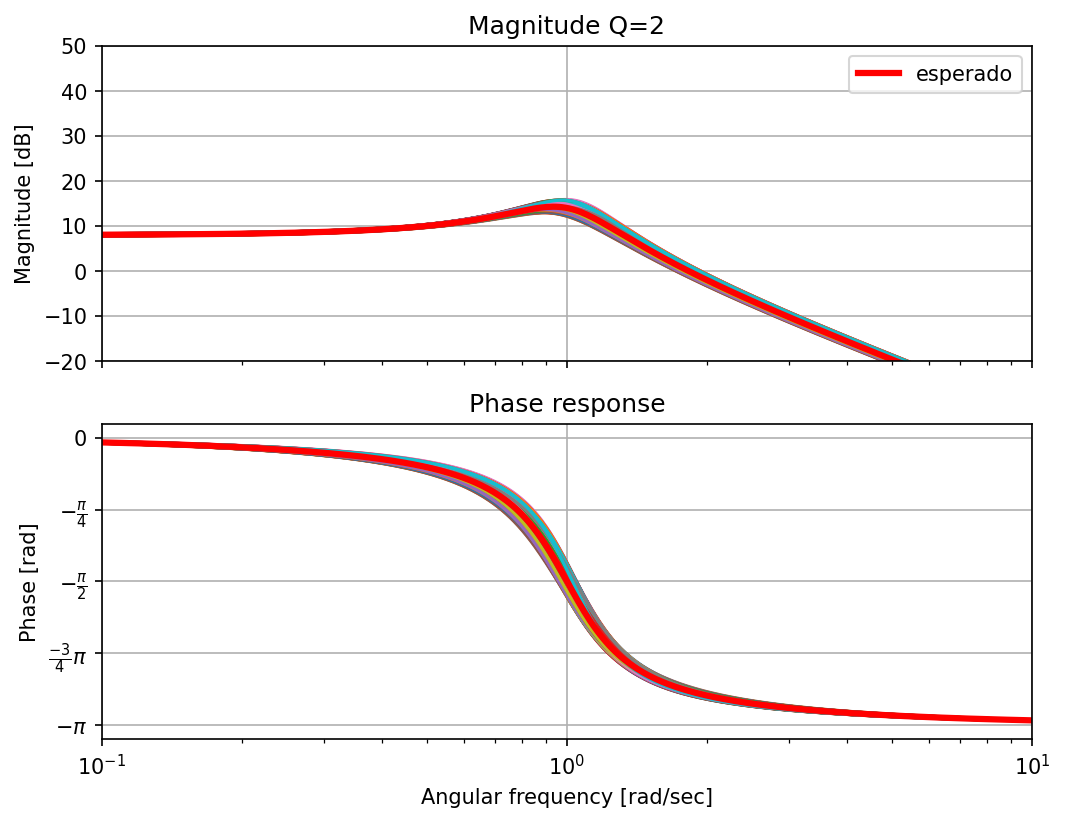

#### Transferencia sampleada al azar para Q=4

<IPython.core.display.Math object>

#### Transferencia deseada para Q=4

<IPython.core.display.Math object>

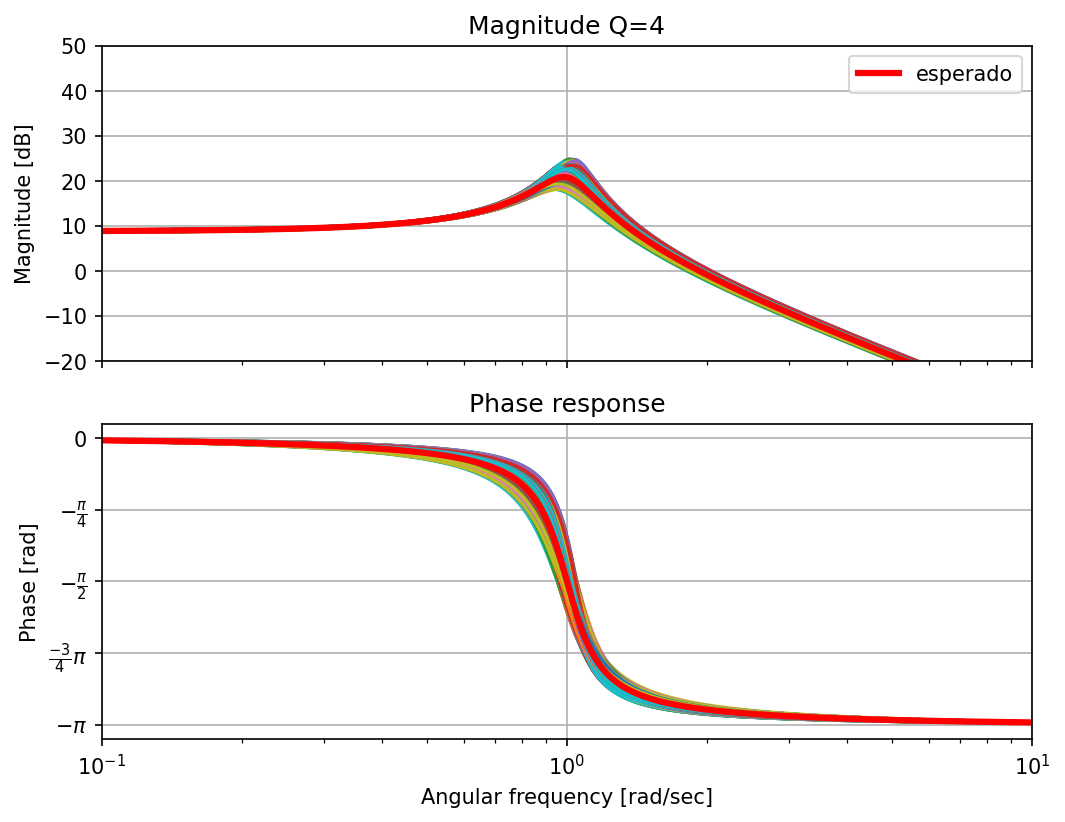

#### Transferencia sampleada al azar para Q=8

<IPython.core.display.Math object>

#### Transferencia deseada para Q=8

<IPython.core.display.Math object>

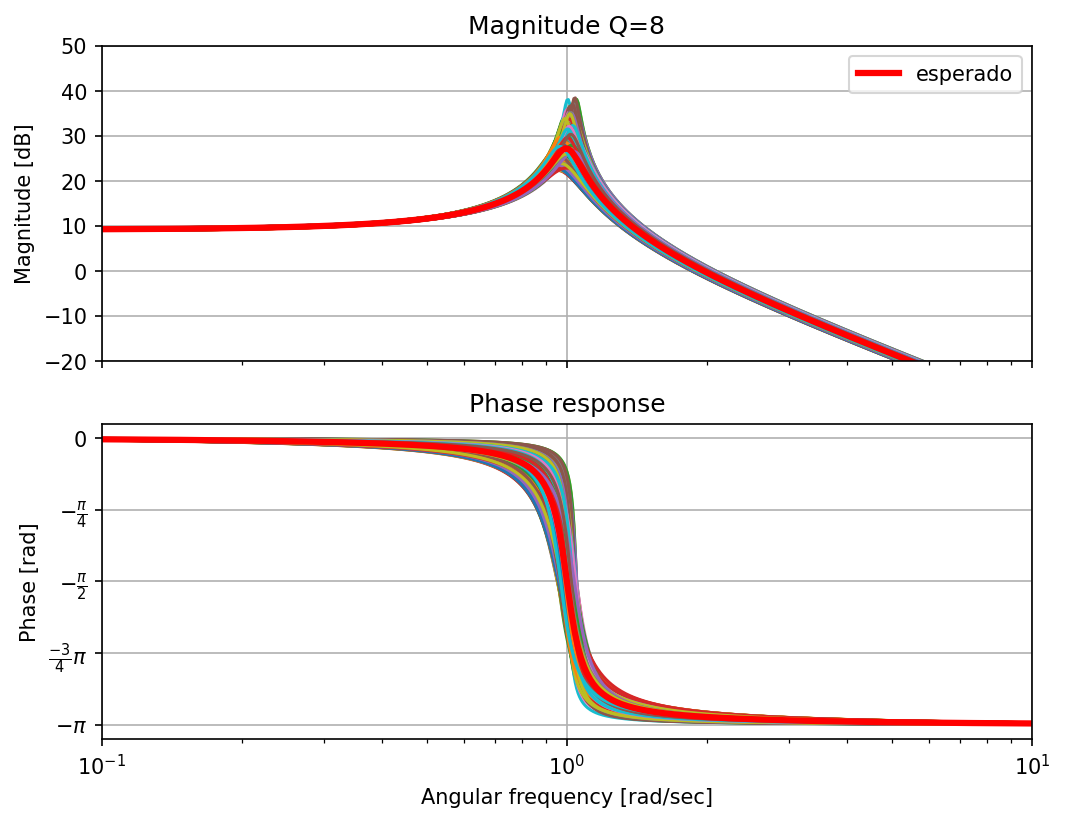

[Volver al índice](#indice)

In [6]:
################
## simulación ##
################

def my_experiment( QQset ):
    # Cantidad de iteraciones o experimentos
    NN = 1000
    # Tolerancia de los componentes
    tol = 5

    # Q y \omega_0 proyectados
    QQ = QQset
    W0 = 1

    # Valores de los componentes 
    CC = 1
    RR = 1
    RB = (2-1/QQ)*RR

    # Valores de los componentes para cada iteración:
    # Cada valor es muestreado independientemente de una distribución uniforme,
    # limitada por la tolerancia impuesta.
    all_C = np.random.uniform(CC * (100-tol/2)/100 , CC * (100+tol/2)/100, size=NN )
    all_R = np.random.uniform(RR * (100-tol/2)/100 , RR * (100+tol/2)/100, size=NN )
    all_RB = np.random.uniform(RB * (100-tol/2)/100 , RB * (100+tol/2)/100, size=NN )

    plt.close('all')

    fig_hdl = plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    axes_hdl = fig_hdl.subplots(2, 1, sharex='col')
    fig_id = fig_hdl.number

    # analizaremos cada iteración resultante
    for (this_C, this_R, this_RB) in zip( all_C, all_R, all_RB):

        this_KK = 1 + this_RB/this_R
        this_QQ = 1/(3-this_KK)
        this_w0 = 1/this_R/this_C

        num = [this_KK * (this_w0**2)]
        den = [1, this_w0/this_QQ, this_w0**2]

        my_tf = TransferFunction( num, den )

        _, axes_hdl = bodePlot(my_tf, fig_id)


    # visualizamos la última realización a modo de ejemplo
    print_subtitle('Transferencia sampleada al azar para Q={:d}'.format(QQset))

    pretty_print_bicuad_omegayq(num,den)

    # finalmente ploteamos también la transferencia con los valores esperados
    # sin incertidumbre alguna sobre sus valores.
    KK = 1 + RB/RR
    QQ = 1/(3-KK)
    WW0 = 1/RR/CC

    num = [KK * (WW0**2)]
    den = [1, WW0/QQ, WW0**2]

    # visualizamos la transferencia esperada o media
    print_subtitle('Transferencia deseada para Q={:d}'.format(QQset))

    pretty_print_bicuad_omegayq(num,den)

    my_tf = TransferFunction( num, den )

    w, mag, phase = my_tf.bode(n=300)

    (mag_ax_hdl, phase_ax_hdl) = axes_hdl

    plt.sca(mag_ax_hdl)
    plt.semilogx(w, mag, '-r', label = 'esperado', linewidth=3 )    # Bode magnitude plot

    plt.title('Magnitude Q={:d}'.format(QQset))
    plt.legend()
    plt.ylim([-20, 50])

    plt.sca(phase_ax_hdl)
    plt.semilogx(w, phase*np.pi/180, '-r', linewidth=3)    # Bode phase plot
    plt.xlim([.1, 10])
    plt.show()
    
    return( all_C, all_R, all_RB )

# enlace para presentar los resultados.
display(Markdown(r'<a id=''2.b''></a>'))

all_Qset = [2, 4, 8]

all_C, all_R, all_RB = my_experiment( QQset = all_Qset[0] )

results = np.vstack([all_C, all_R, all_RB]).transpose()
list_results = [results]

for ii in range(1, len(all_Qset)):
    all_C, all_R, all_RB = my_experiment( QQset = all_Qset[ii] )
    results = np.vstack([all_C, all_R, all_RB]).transpose()
    list_results += [results]
    
results = np.stack( list_results, axis=2 )

# enlace para volver al índice principal.
display(Markdown(r'[Volver al índice](#indice)'))



In [7]:
results = np.stack( list_results, axis=2 )


Para luego analizar estadísticamente la distribución de cada parámetro.

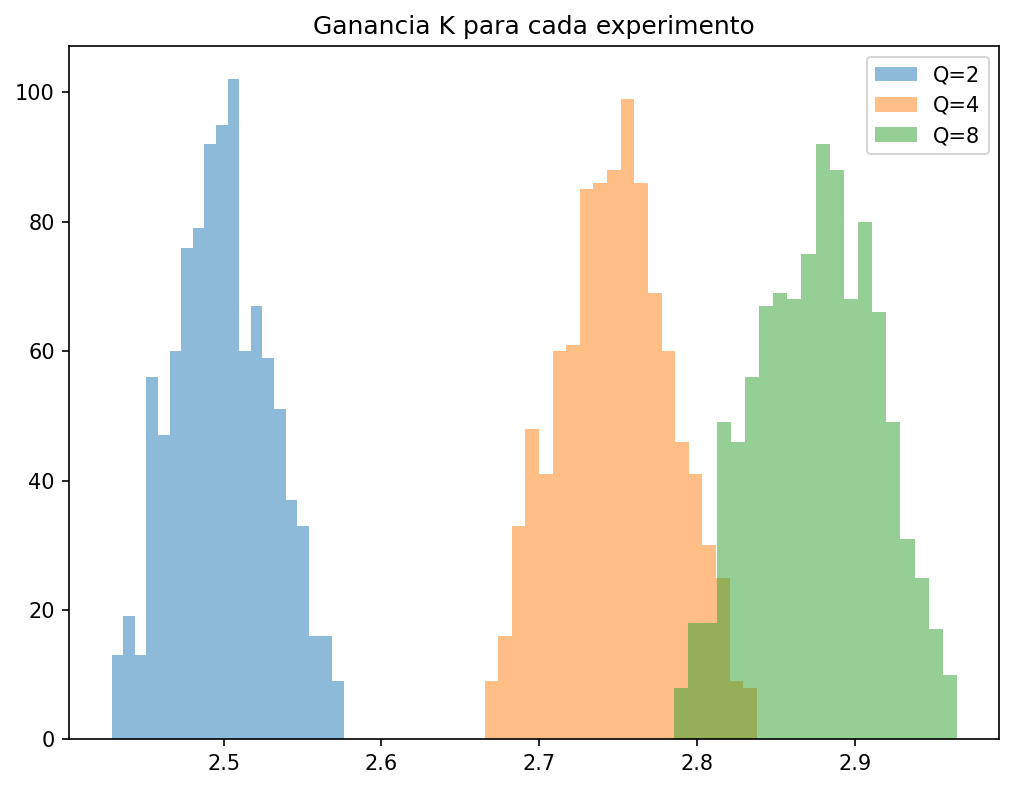

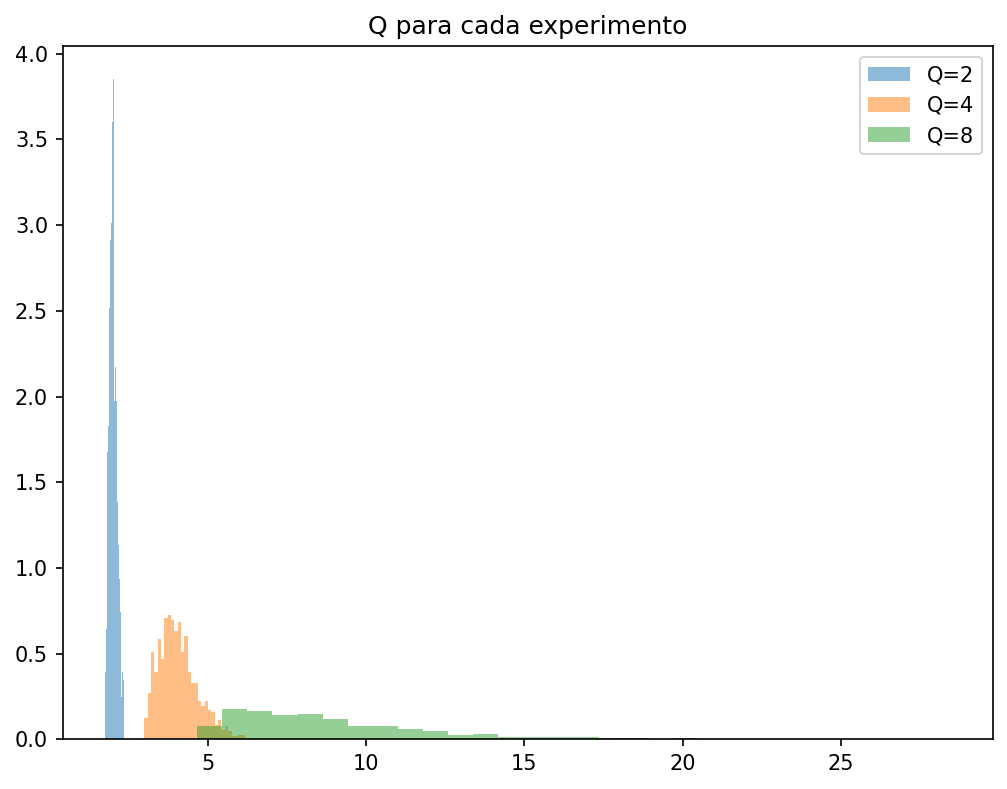

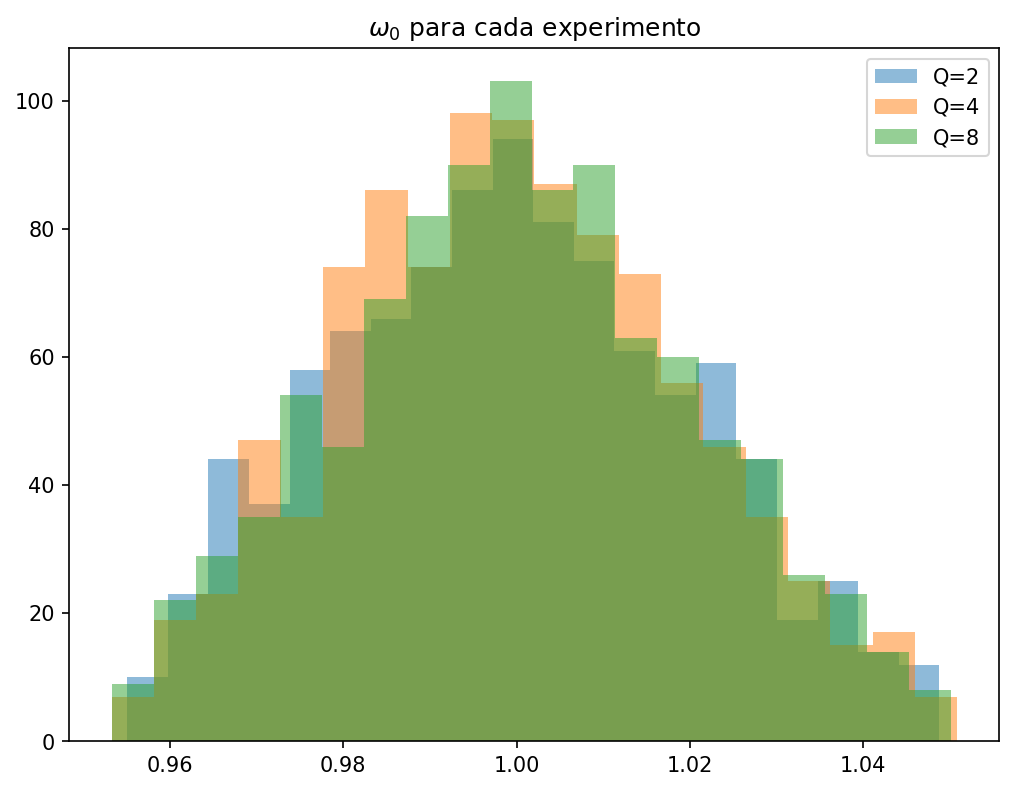

In [8]:
# Ahora vamos a hacer un estudio estadístico de los parámetros Q y \omega_0
# calculo los valores de los parámetros para TODAS las iteraciones
all_KK = 1 + results[:,2,:]/results[:,1,:]
all_QQ = 1/(3-all_KK)
all_w0 = 1/results[:,1,:]/results[:,0,:]

plt.figure()
#plt.hist( 20*np.log10(all_KK), 20 )

for ii in range(len(all_Qset)):
    plt.hist( all_KK[:,ii], 20, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )
plt.title('Ganancia K para cada experimento')
plt.legend()

#plt.figure(figsize=(fig_sz_x*6/10, fig_sz_y*4/10), dpi= fig_dpi, facecolor='w', edgecolor='k')
plt.figure()
for ii in range(len(all_Qset)):
    plt.hist( all_QQ[:,ii], 30, alpha=0.5, density=True, label='Q={:d}'.format(all_Qset[ii]) )

#plt.xlim([0,20])
plt.title('Q para cada experimento')
plt.legend()

plt.figure()
for ii in range(len(all_Qset)):
    plt.hist( all_w0[:,ii], 20, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )

plt.title('$\omega_0$ para cada experimento')
plt.legend()



Como se puede ver en los histogramas, la dispersión o varianza de los parámetros $\omega_0$ y $K$ no se ve alterada por el valor de $Q$ a implementar. Por otro lado, el parámetro $Q$ es el más afectado o sensible a la tolerancia de los componentes en la topología Sallen-Key. El $Q$ depende de la ganancia $K$, que a su vez depende de la relación de dos resistores ($R_a$ y $R_b$). Esta alta sensibilidad puede mitigarse, o bien utilizando resistores con tolerancias bajas (<= 1%), o limitando que el $Q$ a implementarse sea bajo, de forma tal que la ganancia a implementar no afecte tanto.

Finalmente se presenta un análisis cuantitativo de la dispersión de Q

In [9]:
# Pandas es un módulo para la gestión de tablas y análisis de datos
import pandas as pd

dfQ = pd.DataFrame(data = all_QQ, 
                  columns = all_Qset)

# enlace para presentar los resultados.
display(Markdown(r'<a id=''2.c''></a>'))

print_subtitle('2.c) Descripción cuantitativa de los valores de Q')

display(dfQ.describe())


<a id=2.c></a>

#### 2.c) Descripción cuantitativa de los valores de Q

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,2.005499,4.064417,9.077127
std,0.125205,0.609933,3.608753
min,1.751403,2.988501,4.662802
25%,1.913204,3.625577,6.532449
50%,1.994833,3.984751,8.145975
75%,2.089835,4.422698,10.604673
max,2.359282,6.173718,28.459054


Como se puede ver en el desvío standard (std) o en los valores mínimos y máximos la dispersión de $Q$ aumenta a medida que el Q a implementarse aumenta.

Esto mismo no se verifica para $K$ ni $\omega_0$ como se muestra a continuación.

In [10]:
dfK = pd.DataFrame(data = all_w0, 
                  columns = all_Qset)
print_subtitle('Descripción cuantitativa de los valores de ganancia $\omega_0$')

display(dfK.describe())

dfK = pd.DataFrame(data = all_KK, 
                  columns = all_Qset)
print_subtitle('Descripción cuantitativa de los valores de ganancia K')

display(dfK.describe())

# enlace para volver al índice principal.
display(Markdown(r'[Volver al índice](#indice)'))


#### Descripción cuantitativa de los valores de ganancia $\omega_0$

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,0.999475,0.999633,1.000255
std,0.020367,0.019797,0.020127
min,0.955072,0.953293,0.953389
25%,0.984288,0.985050,0.986617
50%,0.999128,0.999147,0.999804
75%,1.014329,1.013249,1.013845
max,1.048783,1.050815,1.050070


#### Descripción cuantitativa de los valores de ganancia K

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,2.499457,2.748690,2.876039
std,0.030778,0.035747,0.038439
min,2.429029,2.665384,2.785537
25%,2.477317,2.724182,2.846918
50%,2.498705,2.749043,2.877240
75%,2.521493,2.773894,2.905702
max,2.576142,2.838023,2.964862


[Volver al índice](#indice)

<a id='2.d'></a>

### 2.d) Conclusiones

Los análisis de sensibilidad y Montecarlo evidencian las limitaciones que tiene la topología Sallen-Key para implementar filtros pasabajos de Q moderados a elevados. Como referencia se suele adoptar esta topología cuando se necesita un filtro de un solo opamp, y el $Q$ a implementar es menor a 3.

[Volver al índice](#indice)

<a id='3.a'></a>

### 3.a) Simulación circuital

En esta sección se realizarán las simulaciones finales, que tienen como objetivo corroborar los análisis realizados en las secciones previas, y eventualmente ampliar alguna simulación aprovechando el motor de simulación de [LTspice](https://www.analog.com/en/design-center/design-tools-and-calculators/ltspice-simulator.html) y los modelos de componentes incluídos, especialmente los amplificadores operacionales.

<img src="./Sallen-Key circuito.png" align="center" width="90%" /> 


[Volver al índice](#indice)

<a id='3.b'></a>

### 3.b) Resultados cualitativos 

Analizando la respuesta en frecuencia para los valores de Q (2, 4 y 8) analizados, se puede comparar visualmente como crece la dispersión para los factores de selectividad elevados (>3) según analizamos en las [expresiones de sensibilidad](#1.e) y la [simulación numérica](#2.b).

### Q=2

<img src="./Sallen-Key transferencia Q2.jpg" align="center" width="90%" /> 

### Q=4

<img src="./Sallen-Key transferencia Q4.jpg" align="center" width="90%" /> 

### Q=8

<img src="./Sallen-Key transferencia Q8.jpg" align="center" width="90%" /> 


[Volver al índice](#indice)

<a id='3.c'></a>

### 3.c) Simulación circuital

Analizaremos ahora las mediciones automáticas realizadas en LTspice con la finalidad de realizar una comparación entre la simulación circuital y la numérica.


[Volver al índice](#indice)

[Volver al índice](#indice)

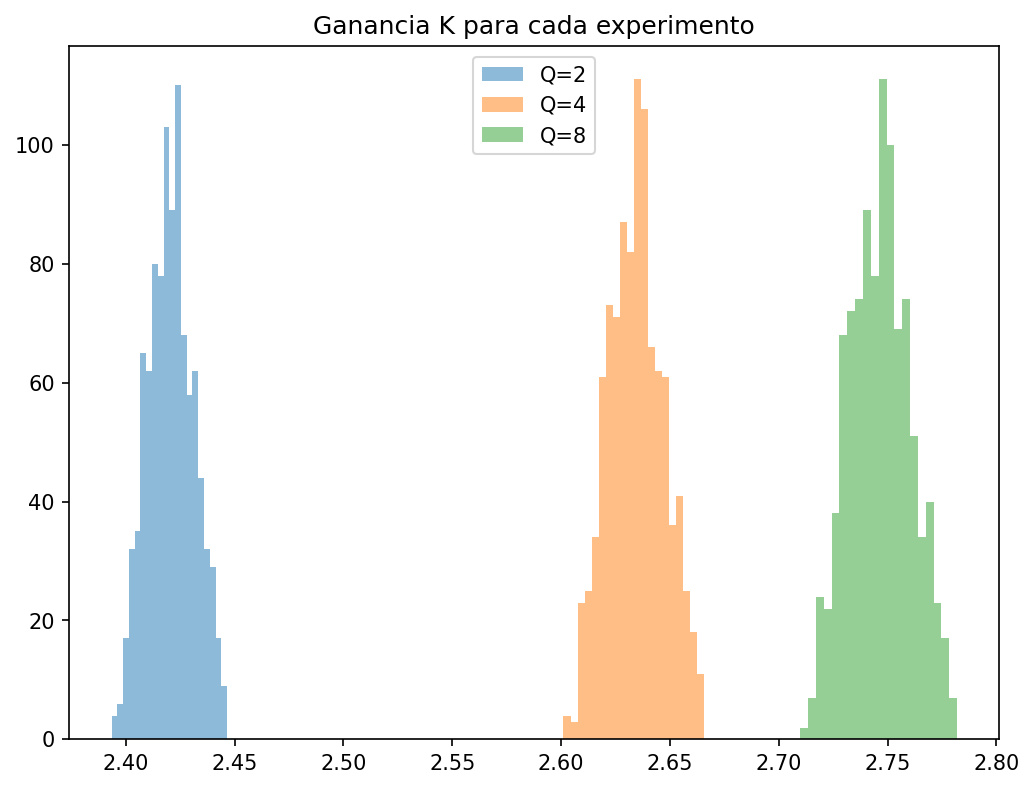

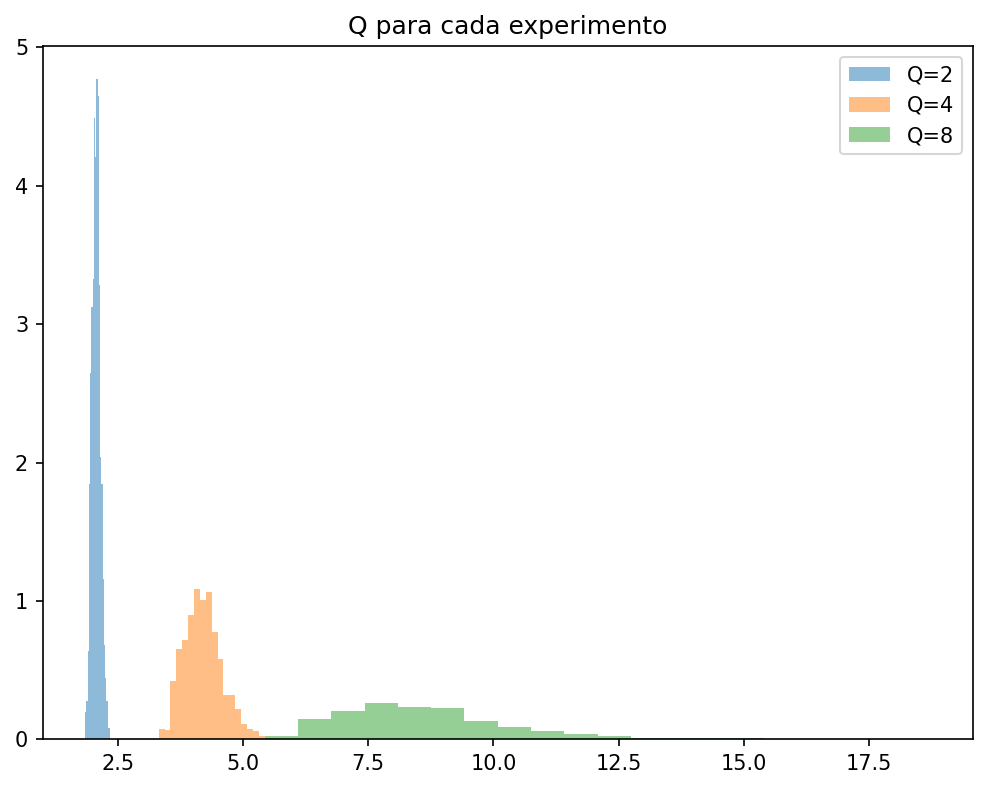

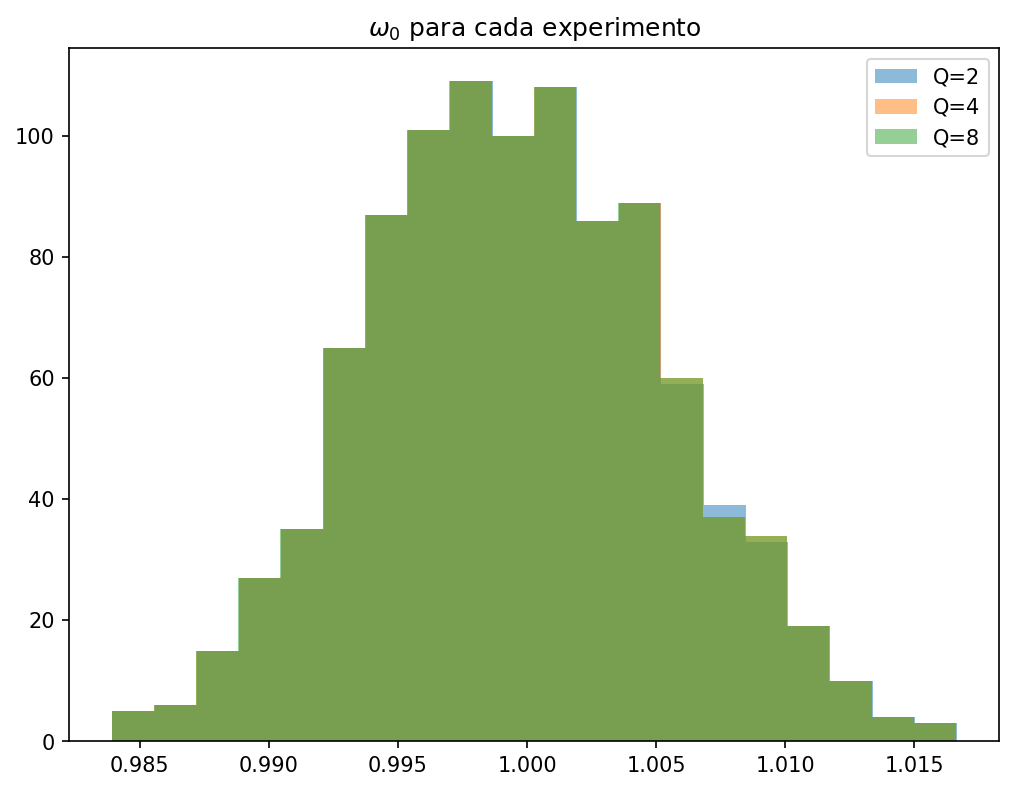

In [11]:


df = []


for ii in range(len(all_Qset)):
    # read the CSV file into a pandas dataframe
    df += [pd.read_csv('Sallen Key montecarlo Q{:d}.csv'.format(all_Qset[ii]))]

for ii in range(len(all_Qset)):
    plt.hist( df[ii]['k_meas'] , 20, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )
plt.title('Ganancia K para cada experimento')
plt.legend()

plt.figure()
for ii in range(len(all_Qset)):
    # por como lo mido, tengo que dividir por el k. Porque mido T(wo) = k*Q
    plt.hist( df[ii]['q_meas']/df[ii]['k_meas'], 20, density = True, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )

plt.title('Q para cada experimento')
plt.legend()

plt.figure()
for ii in range(len(all_Qset)):
    plt.hist( df[ii]['fo_meas'], 20, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )

plt.title('$\omega_0$ para cada experimento')
plt.legend()

# enlace para volver al índice principal.
display(Markdown(r'[Volver al índice](#indice)'))

# display the plot
plt.show()


In [12]:
# enlace para presentar los resultados.
display(Markdown(r'<a id=''3.d''></a>'))

dfQ_ltspice = pd.concat([df[0]['q_meas']/df[0]['k_meas'], df[1]['q_meas']/df[1]['k_meas'], df[2]['q_meas']/df[2]['k_meas']], axis=1)
dfQ_ltspice.columns = all_Qset
    
print_subtitle('3.d) Descripción cuantitativa de los valores de Q')

display(Markdown(r'### Con LTspice'))

display(dfQ_ltspice.describe())

display(Markdown(r'### Con Python'))

display(dfQ.describe())


# enlace para volver al índice principal.
display(Markdown(r'[Volver al índice](#indice)'))


<a id=3.d></a>

#### 3.d) Descripción cuantitativa de los valores de Q

### Con LTspice

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,2.067153,4.201468,8.659827
std,0.083575,0.378781,1.781037
min,1.846792,3.316699,5.433135
25%,2.008463,3.930336,7.410486
50%,2.064890,4.176015,8.363912
75%,2.120516,4.426437,9.506762
max,2.346078,5.668244,18.728285


### Con Python

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,2.005499,4.064417,9.077127
std,0.125205,0.609933,3.608753
min,1.751403,2.988501,4.662802
25%,1.913204,3.625577,6.532449
50%,1.994833,3.984751,8.145975
75%,2.089835,4.422698,10.604673
max,2.359282,6.173718,28.459054


[Volver al índice](#indice)

<a id='3.e'></a>

### 3.e) Conclusiones

Como se puede observar, los resultados son concordantes entre métodos de simulación. Los valores medios de Q están dentro de la tolerancia esperada en ambos métodos de simulación (<10%) y para los casos de Q= (2, 4) las tolerancias decrecen monótonamente.  Cabe destacar que los parámetros comparados ni se generan, ni se miden de la misma manera, lo cual podría explicar las discrepancias. En cualquier caso, y dado que las simulaciones han sido concordantes, se podría pasar a una etapa de fabricación de un prototipo.

[Volver al índice](#indice)